In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import Kitti
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import random
%matplotlib inline

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [3]:
CONFIDENCE_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5
DC_THRESHOLD=1000 # object that is shaller than this is believed to be too far away. thus not safety relevent
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
seed_number = 4
torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

In [4]:
# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/KITTI_Syn_ControlNet_Canny/',  transform=ToTensor(), download = False)

# Get the k-th image in the list () and its ground truth labels
image_index = 0
# image_index = 1 # With train errors

# Note that label_real and label_syn are the same
image_real, label_real = kitti_real_dataset[image_index]
image_syn, label_syn  = kitti_syn_dataset[image_index]

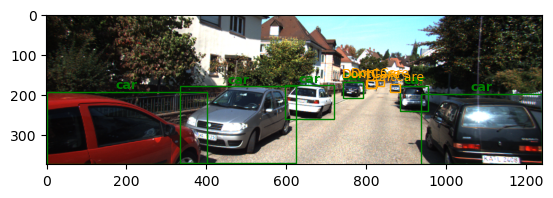

In [5]:
# Display the image with the bounding box
fig_real, ax = plt.subplots(1)
ax.imshow(image_real.permute(1, 2, 0))

for box in label_real:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    #x1, y1, x2, y2 = box

    if box["type"] == "Pedestrian":
        ax.text((x1+x2)/2, y1, 'pedestrian', ha='center', va='bottom', transform=ax.transData, fontsize=9, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
    elif box["type"] == "Car":
        ax.text((x1+x2)/2, y1, 'car', ha='center', va='bottom', transform=ax.transData, fontsize=9, color='green',weight='bold')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=1)
    elif box["type"] == "Van":
        ax.text((x1+x2)/2, y1, 'van', ha='center', va='bottom', transform=ax.transData, fontsize=9, color='blue')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=1)
    elif box["type"] == "Truck":
        ax.text((x1+x2)/2, y1, 'truck', ha='center', va='bottom', transform=ax.transData, fontsize=9, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    elif box["type"] == "Cyclist":
        ax.text((x1+x2)/2, y1, 'cyclist', ha='center', va='bottom', transform=ax.transData, fontsize=9, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    else:
        # For the other classes, we use gray
        ax.text((x1+x2)/2, y1, box["type"], ha='center', va='bottom', transform=ax.transData, fontsize=9, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1) 
    ax.add_patch(rect)
plt.show()

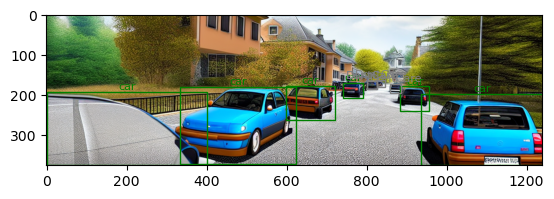

In [6]:
fig_syn, ax = plt.subplots(1)
ax.imshow(image_syn.permute(1, 2, 0))
for box in label_syn:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    #x1, y1, x2, y2 = box

    if box["type"] == "Pedestrian":
        ax.text((x1+x2)/2, y1, 'pedestrian', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
    elif box["type"] == "Car":
        ax.text((x1+x2)/2, y1, 'car', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='green')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=1)
    elif box["type"] == "Van":
        ax.text((x1+x2)/2, y1, 'van', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='blue')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=1)
    elif box["type"] == "Truck":
        ax.text((x1+x2)/2, y1, 'truck', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    elif box["type"] == "Cyclist":
        ax.text((x1+x2)/2, y1, 'cyclist', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    else:
        # For the other classes, we use gray
        ax.text((x1+x2)/2, y1, box["type"], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='gray')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='gray', linewidth=1)
    ax.add_patch(rect)
plt.show()


In [7]:
# Load the pre-trained model (note that this is not really ideal, as the model has more classes based on COCO)
model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

image_real = image_real.to(device)
# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_real])
    
# Display the image with the predicted bounding boxes
image_real = image_real.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()

print(boxes,labels,scores)

C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCOS_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FCOS_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[3.48671021e+02 1.81025238e+02 6.13509277e+02 3.46583954e+02]
 [8.37572992e-01 1.99758560e+02 3.87490143e+02 3.74818756e+02]
 [8.81365173e+02 1.79512970e+02 9.55061646e+02 2.38217621e+02]
 [9.45837952e+02 2.10037766e+02 1.24161877e+03 3.73269073e+02]
 [7.39814575e+02 1.69235107e+02 7.88317078e+02 2.08067139e+02]
 [6.03781067e+02 1.75787338e+02 7.17822571e+02 2.59660736e+02]
 [7.80080994e+02 1.71592133e+02 8.02202393e+02 1.99800598e+02]
 [8.61787109e+02 1.70580841e+02 8.86836975e+02 1.93795135e+02]
 [8.03980469e+02 1.65156281e+02 8.25916199e+02 1.83816010e+02]
 [8.29842773e+02 1.64248672e+02 8.44630005e+02 1.80257111e+02]
 [1.18246448e+03 1.90003601e+02 1.24155823e+03 2.41137894e+02]
 [1.18248364e+03 1.89880173e+02 1.24165808e+03 2.40935196e+02]
 [9.47505920e+02 1.78252106e+02 9.70456177e+02 1.95947647e+02]
 [8.81365173e+02 1.79512970e+02 9.55061646e+02 2.38217621e+02]
 [8.80557007e+02 1.78301956e+02 8.98372742e+02 2.14544266e+02]
 [9.46438599e+02 2.11159439e+02 1.10414294e+03 3.724073

car
car
car
car


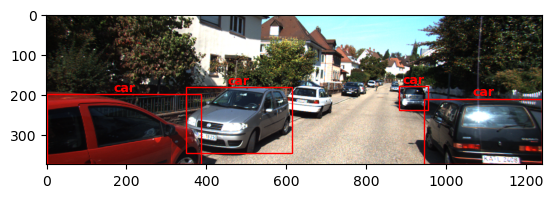

car
car
car
car
car


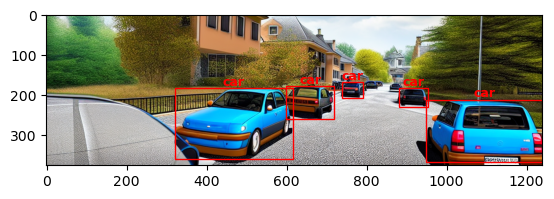

In [8]:
fig, ax = plt.subplots(1)
ax.imshow(image_real.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box
    area = (x2 - x1) * (y2 - y1)
    if score > CONFIDENCE_THRESHOLD and area>DC_THRESHOLD:
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=9, color='red',weight='bold')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()


image_syn = image_syn.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn])

# Display the image with the predicted bounding boxes
image_syn = image_syn.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()

fig, ax = plt.subplots(1)
ax.imshow(image_syn.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box
    area = (x2 - x1) * (y2 - y1)
    if score > CONFIDENCE_THRESHOLD and area>DC_THRESHOLD:
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=9, color='red',weight='bold')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()